# AI Text Detection using Transformer

This notebook implements a transformer-based model to detect AI-written text.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

/home/super-pc2/miniconda3/envs/biorag/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Load and preprocess data
df = pd.read_csv("../data/merged.csv")
print(f"Dataset size: {len(df)}")
print(f"Class distribution:\n{df['is_human'].value_counts()}")

Dataset size: 134633
Class distribution:
is_human
1    70233
0    64400
Name: count, dtype: int64


In [4]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 512  # Maximum sequence length

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Dropout(dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)  # 2 classes: human/AI
        )
    
    def forward(self, input_ids, attention_mask):
        # Create padding mask
        padding_mask = (attention_mask == 0)
        
        # Embedding and positional encoding
        x = self.embedding(input_ids)
        x = self.pos_encoder(x)
        
        # Transformer encoder
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification head
        x = self.classifier(x)
        return x

In [7]:
# Prepare data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df['is_human'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['is_human']
)

train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(vocab_size=tokenizer.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), accuracy_score(all_labels, all_preds)

In [10]:
# Training loop
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

/home/super-pc2/miniconda3/envs/biorag/lib/python3.9/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1/10:
Train Loss: 0.4115, Train Acc: 0.8074
Val Loss: 0.5238, Val Acc: 0.8402
Epoch 2/10:
Train Loss: 0.2958, Train Acc: 0.8703
Val Loss: 0.5071, Val Acc: 0.8555
Epoch 3/10:
Train Loss: 0.2569, Train Acc: 0.8902
Val Loss: 0.4946, Val Acc: 0.8757
Epoch 4/10:
Train Loss: 0.2341, Train Acc: 0.9004
Val Loss: 0.4969, Val Acc: 0.8752
Epoch 5/10:
Train Loss: 0.2143, Train Acc: 0.9113
Val Loss: 0.5001, Val Acc: 0.8676
Epoch 6/10:
Train Loss: 0.1983, Train Acc: 0.9176
Val Loss: 0.4866, Val Acc: 0.8838
Epoch 7/10:
Train Loss: 0.1846, Train Acc: 0.9241
Val Loss: 0.4868, Val Acc: 0.8856
Epoch 8/10:
Train Loss: 0.1712, Train Acc: 0.9300
Val Loss: 0.4869, Val Acc: 0.8770
Epoch 9/10:
Train Loss: 0.1582, Train Acc: 0.9362
Val Loss: 0.4794, Val Acc: 0.8862
Epoch 10/10:
Train Loss: 0.1470, Train Acc: 0.9397
Val Loss: 0.4860, Val Acc: 0.8731


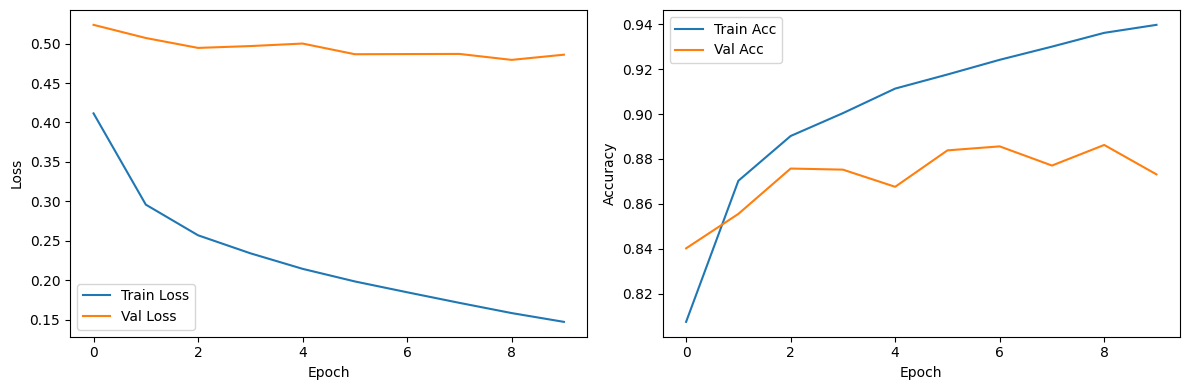

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
print(f'Best model validation accuracy: {val_acc:.4f}')

Best model validation accuracy: 0.8862


In [13]:
# Function to predict on new text
def predict_text(text):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    return {
        'prediction': 'Human' if prediction.item() == 1 else 'AI',
        'confidence': probabilities[0][prediction].item()
    }